In the locally weighted model, we have proved the similarity between data does have a positive effect on predictions.<br>
However, to find the closest k points for one query point, we have to iterate the whole dataset at least k times, which can be really expensive. We cannot rely on this method in production.<br>
To save computation time, here we are going to refer to Local Sensitive Hashing(LSH)<br>
Read https://en.wikipedia.org/wiki/Locality-sensitive_hashing for more information<br><br>

The basic idea behind LSH is that we want to narrow down our searching scope quickly and find the closest neighbors in a smal group of data. To achieve that goal, we divide data into n groups, to determine one query data point belongs to this group or not, we use a random generated vector with the same shape as the query point, calcualte the dot product between the random vector and the query point, if it's greater than 0, we say this point belongs to this group, otherwise it doesn't. (Actually random vector turns out to be a very good initialization). We generate n different random vector and calculate dot product for each, then we can get a vector of n 0/1 variables. 

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random
from itertools import combinations
from sklearn.metrics.pairwise import cosine_similarity
import math

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 2000
%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
del df['id']

In [4]:
dummy_df = pd.get_dummies(df)

In [5]:
y = dummy_df['loss'].values
del dummy_df['loss']

In [7]:
zscore_df = (dummy_df - dummy_df.mean()) / dummy_df.std()
zscore_df = zscore_df.values

In [8]:
def generate_random_vectors(num_vector, dim):
    return np.random.randn(dim, num_vector)

In [9]:
def train_lsh(data, num_vector=16, seed=None):
    dim = data.shape[1]
    if seed is not None:
        np.random.seed(seed)
    random_vectors = generate_random_vectors(num_vector, dim)
    
    powers_of_two = 1 << np.arange(num_vector-1, -1, -1)
    
    table = {}
    
    bin_index_bits = (data.dot(random_vectors) >= 0)
    
    bin_indices = bin_index_bits.dot(powers_of_two)
    
    for data_index, bin_index in enumerate(bin_indices):
        table.setdefault(bin_index, []).append(data_index)
        
    model = {'data': data,
             'bin_index_bits': bin_index_bits,
             'bin_indices': bin_indices,
             'table': table,
             'random_vectors': random_vectors,
             'num_vectors': num_vector}
    
    return model

In [10]:
# Check it out how fast it can be
model = train_lsh(zscore_df, 6)

In [11]:
assert len(zscore_df) == len([item for sublist in model['table'].values() for item in sublist])

A vector of n random variables means 2^n different groups

In [12]:
assert np.power(2, 6)-1 == max(model['table'].keys())

Check Point<br>

Take a look at the data points in the first group

In [13]:
counts = {k: len(v) for k, v in model['table'].items()}

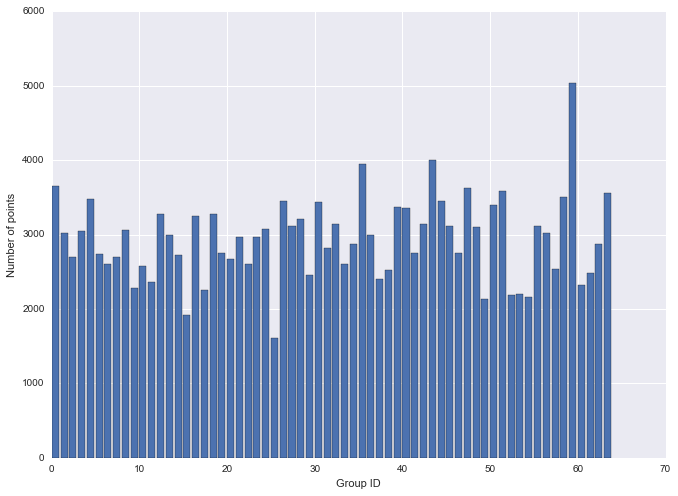

In [14]:
plt.figure(figsize=(11, 8))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Group ID')
plt.ylabel('Number of points')

In [15]:
def calculate_average_similarity(data):
    num_points = data.shape[0]
    f = math.factorial
    combinations = f(num_points) / f(num_points - 2) / f(2)
    return (cosine_similarity(data).sum() - num_points * 1) / 2 / combinations

In [87]:
for group_id, indexs in model['table'].items():
    data_points = zscore_df[indexs]
    print('Average cosine similarity between each data points in group {} is {}'.format(
        group_id, calculate_average_similarity(data_points)))

Average cosine similarity between each data points in group 0 is 0.02891507316488995
Average cosine similarity between each data points in group 1 is 0.02309168539612048
Average cosine similarity between each data points in group 2 is 0.035167103220146545
Average cosine similarity between each data points in group 3 is 0.020056078657011128
Average cosine similarity between each data points in group 4 is 0.025337098006906943
Average cosine similarity between each data points in group 5 is 0.030226429122155292
Average cosine similarity between each data points in group 6 is 0.03157254288548797
Average cosine similarity between each data points in group 7 is 0.027640677869021982
Average cosine similarity between each data points in group 8 is 0.026622299536373427
Average cosine similarity between each data points in group 9 is 0.020074207588358525
Average cosine similarity between each data points in group 10 is 0.03361635282461803
Average cosine similarity between each data points in gro

The similarity is really bad... probably LSH works better for categorical variables. <br>
TODO: convert the original dataset to 0/1 variables.<br>
For categorical variables, apply one hot encoding.<br>
For continuous variables, divide them to different groups

In [20]:
continuous_vars = [c for c in dummy_df.columns if c.startswith('cont')]

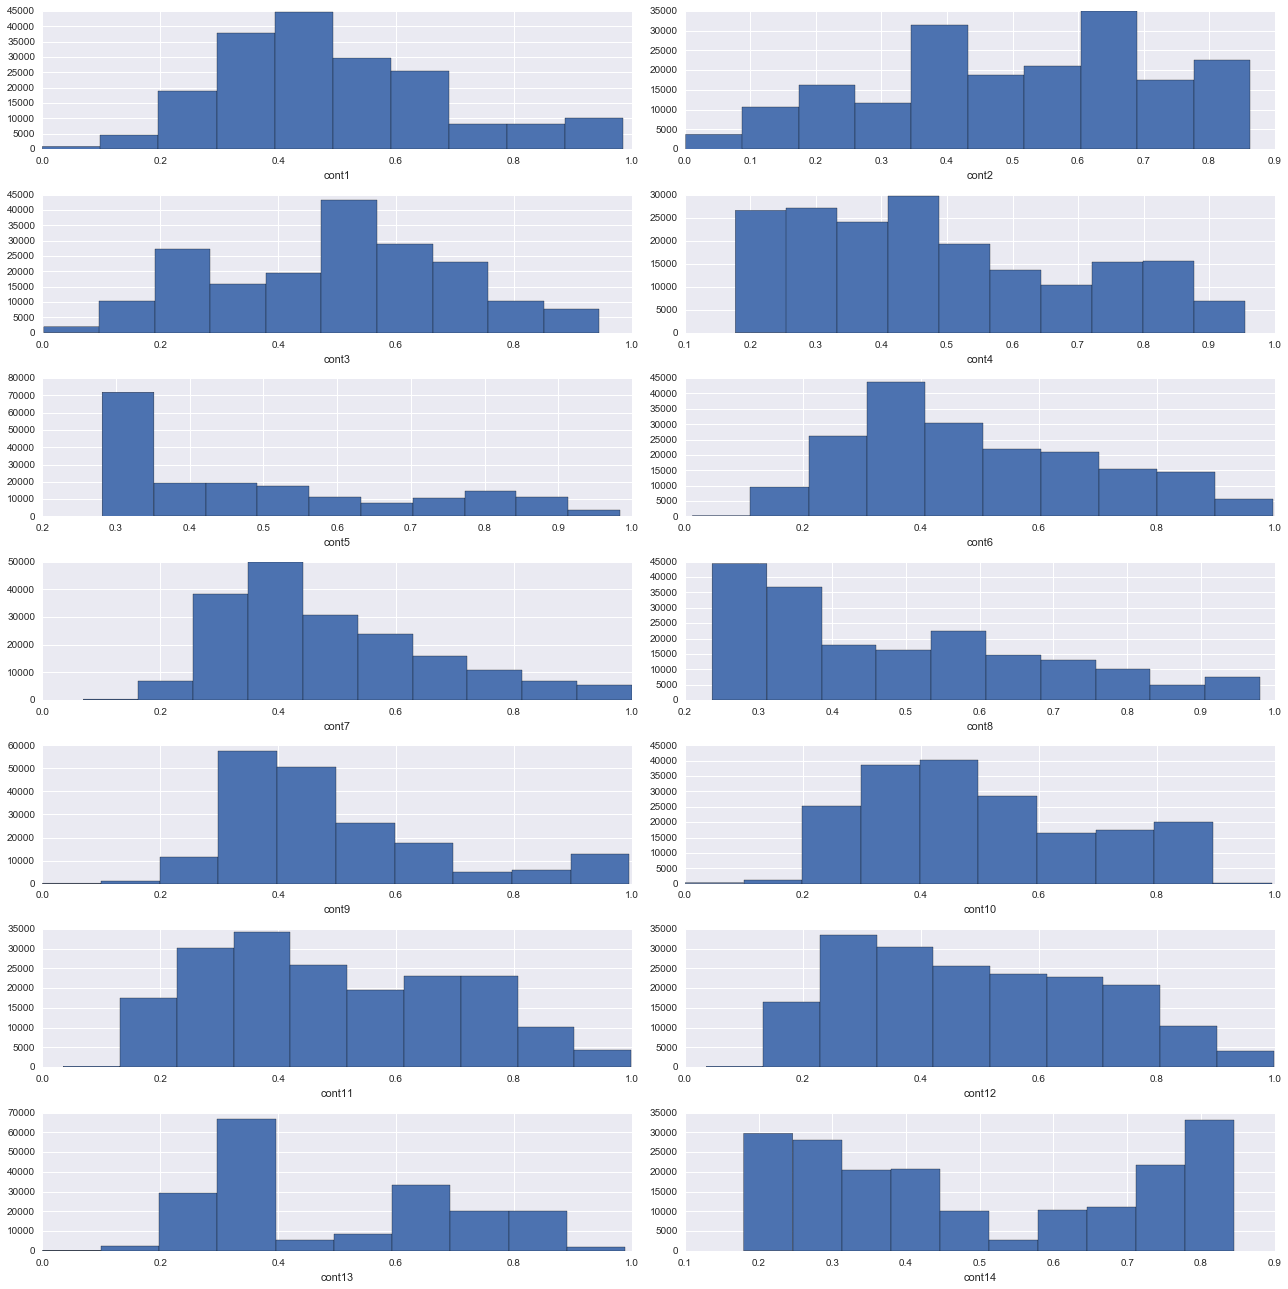

In [66]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(18, 18))
for i, c in enumerate(continuous_vars):
    sub = plt.subplot(7, 2, i+1)
    sub.set_xlabel(c)
    dummy_df[c].hist()

fig.tight_layout()

Apparently, they are not normal distributed, regardless of skweness, some features, i.e, cont14, absolutly cannot be expressed as a normal distribution. So the skweness corrections we took in linear regression were wrong.

In [68]:
dummy_df[continuous_vars].describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848


All the continuous variables are from 0 to 1. We decide to divide each continous variables into 10 different groups.<br><br>
10 groups means we need 10 digits to represent all groups. For example, the first group 
[0, 0.1) will be expressed as 0000000001, the second group [0.1, 0.2) 0000000011 and etc. 
<br><br>This representation method can keep the relative value information in the dataset, for example, the cosine distance between 0000000111(Query point) and 0000000011(A), which is 0.18,  is shorter than the cosine distance between 0000000111 and 0000000001(B), which is 0.42. This makes senses because A represents data in group [0.1, 0.2) while B represents data in group [0, 0.1), the Query point is in group [0.2, 0.3) so it should have shorter distance to A than B.

In [10]:
continuous_vars = [c for c in dummy_df.columns if c.startswith('cont')]

In [11]:
# Function divides continuous variables into groups
def continuous_to_groups(data, name):
    names = [name+'_{}'.format(i) for i in range(10, 0, -1)]
    decoded_data = []
    for d in data:
        group = d // 0.1 + 1
        zeros = np.zeros(10)
        zeros[-group:] = 1
        decoded_data.append(zeros)
    return pd.DataFrame(decoded_data, index=data.index, columns=names)

In [12]:
original_size = len(dummy_df)
for col in continuous_vars:
    decoded_df = continuous_to_groups(dummy_df[col], col)
    dummy_df = pd.merge(dummy_df, decoded_df, how='inner', left_index=True, right_index=True)
    assert len(dummy_df) == original_size

In [16]:
for c in continuous_vars:
    del dummy_df[c]

In [170]:
def get_sorted_distances_and_index(data, target):
    distances = cosine_similarity(target, data)[0]
    orders = np.argsort(-distances)
    return distances[orders], orders

In [90]:
for z in model['table'][0]:
    target = zscore_df[z]
    distances, idx = get_sorted_distances_and_index(zscore_df, target)
    print('The closest data points from data point {} is {}'.format(z, idx[1:6]))
    break

The closest data points from data point 0 is [ 37634  26102 177514  71709 108119]
